# Durr-Hoyer Algorithm Implementation
## Finding the Maximum using 4 Qubits

The Durr-Hoyer algorithm is a quantum algorithm for finding the minimum/maximum element in an unstructured database. It provides a quadratic speedup compared to classical algorithms.

This implementation uses:
- **4 qubits** for searching
- **Oracle**: X gates + Hadamard + MCX + Hadamard (to implement multi-controlled Z)
- **Diffusion Operator**: Hadamard → X → Multi-controlled Z → X → Hadamard

In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np
from math import pi, sqrt
import matplotlib.pyplot as plt

## Step 1: Define the Oracle
The oracle uses X gates to mark the target state (maximum element).
For this example, we mark state |1111⟩ (15 in decimal) as the maximum.

In [ ]:
def oracle(qc, qubits, target_state=15):
    """
    Oracle that marks the target state using X gates and multi-controlled Z gate.
    Multi-controlled Z is implemented as Hadamard - MCX (multi-controlled X) - Hadamard.
    
    Args:
        qc: QuantumCircuit
        qubits: list of qubit indices
        target_state: the state to mark (default: 15 = |1111⟩)
    """
    # Convert target state to binary representation
    binary = format(target_state, f'0{len(qubits)}b')
    
    # Apply X gates to qubits where target state has 0
    for i, bit in enumerate(binary):
        qubit_index = len(qubits) - 1 - i
        if bit == '0':
            qc.x(qubits[qubit_index])
    
    # Apply multi-controlled Z gate
    if len(qubits) > 1:
        qc.h(qubits[-1])
        qc.mcx(qubits[:-1], qubits[-1])
        qc.h(qubits[-1])
    else:
        qc.z(qubits[0])
    
    # Undo the X gates
    for i, bit in enumerate(binary):
        qubit_index = len(qubits) - 1 - i
        if bit == '0':
            qc.x(qubits[qubit_index])

print("Oracle function defined.")

Oracle function defined.


## Step 2: Define the Diffusion Operator
The diffusion operator amplifies the marked state:
1. Apply Hadamard gates to all qubits
2. Apply X gates to all qubits
3. Apply multi-controlled Z gate
4. Apply X gates to all qubits
5. Apply Hadamard gates to all qubits

In [22]:
def diffusion_operator(qc, qubits):
    """
    Diffusion operator for amplitude amplification.
    Structure: H → X → Multi-controlled Z → X → H
    
    Args:
        qc: QuantumCircuit
        qubits: list of qubit indices
    """
    # Step 1: Apply Hadamard gates
    for qubit in qubits:
        qc.h(qubit)
    
    # Step 2: Apply X gates
    for qubit in qubits:
        qc.x(qubit)
    
    # Step 3: Apply multi-controlled Z gate using H-MCX-H decomposition
    if len(qubits) > 1:
        qc.h(qubits[-1])
        qc.mcx(qubits[:-1], qubits[-1])
        qc.h(qubits[-1])
    else:
        qc.z(qubits[0])
    
    # Step 4: Apply X gates
    for qubit in qubits:
        qc.x(qubit)
    
    # Step 5: Apply Hadamard gates
    for qubit in qubits:
        qc.h(qubit)

print("Diffusion operator function defined.")

Diffusion operator function defined.


## Step 3: Build the Complete Durr-Hoyer Circuit

In [ ]:
def durr_hoyer_circuit(num_qubits=4, target_state=15, num_iterations=None):
    """
    Construct the complete Durr-Hoyer circuit.
    
    Args:
        num_qubits: number of qubits (default: 4)
        target_state: the maximum element to find
        num_iterations: number of Grover iterations (None = optimal)
    
    Returns:
        QuantumCircuit with measurements
    """
    # Create quantum and classical registers
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(num_qubits, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # Step 1: Initialize with Hadamard gates (superposition)
    qc.h(qr)
    qc.barrier()
    
    # Calculate optimal number of iterations if not specified
    if num_iterations is None:
        num_iterations = int(np.pi / 4 * np.sqrt(2**num_qubits))
    
    qc.barrier()
    
    # Step 2: Apply Durr-Hoyer iterations (oracle + diffusion)
    for i in range(num_iterations):
        # Apply oracle to mark target state
        oracle(qc, list(qr), target_state)
        qc.barrier()
        
        # Apply diffusion operator for amplitude amplification
        diffusion_operator(qc, list(qr))
        qc.barrier()
    
    # Step 3: Measure all qubits
    qc.measure(qr, cr)
    
    return qc

# Build the circuit
num_qubits = 4
target_state = 15  # |1111⟩ - maximum value for 4 qubits

circuit = durr_hoyer_circuit(num_qubits=num_qubits, target_state=target_state,num_iterations=5)
print(f"Durr-Hoyer circuit created with {num_qubits} qubits")
print(f"Target state (maximum): {target_state} (|{format(target_state, '04b')}⟩)")

Durr-Hoyer circuit created with 4 qubits
Target state (maximum): 15 (|1111⟩)


## Step 4: Display the Circuit

In [24]:
# Display the circuit
print(circuit)

     ┌───┐ ░  ░                 ░ ┌───┐┌───┐          ┌───┐┌───┐      ░      »
q_0: ┤ H ├─░──░────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──────»
     ├───┤ ░  ░        │        ░ ├───┤├───┤       │  ├───┤├───┤      ░      »
q_1: ┤ H ├─░──░────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──────»
     ├───┤ ░  ░        │        ░ ├───┤├───┤       │  ├───┤├───┤      ░      »
q_2: ┤ H ├─░──░────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──────»
     ├───┤ ░  ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ ┌───┐»
q_3: ┤ H ├─░──░─┤ H ├┤ X ├┤ H ├─░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░─┤ H ├»
     └───┘ ░  ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░ └───┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                ░ ┌───┐┌───┐          ┌───┐┌───┐      ░                 ░ »
«q_0: ──■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────

## Step 5: Execute the Circuit

In [25]:
# Use AER simulator
simulator = AerSimulator()

# Transpile the circuit
transpiled_circuit = transpile(circuit, simulator)

# Execute the circuit
job = simulator.run(transpiled_circuit, shots=1000)
result = job.result()

# Get the measurement results
counts = result.get_counts(transpiled_circuit)

print("\nMeasurement Results:")
print("="*50)
for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    state_value = int(bitstring, 2)
    percentage = (count / 1000) * 100
    print(f"State |{bitstring}⟩ (decimal: {state_value:2d}): {count:4d} shots ({percentage:5.1f}%)")


Measurement Results:
State |1111⟩ (decimal: 15):  116 shots ( 11.6%)
State |1110⟩ (decimal: 14):   75 shots (  7.5%)
State |1101⟩ (decimal: 13):   71 shots (  7.1%)
State |1000⟩ (decimal:  8):   65 shots (  6.5%)
State |1010⟩ (decimal: 10):   65 shots (  6.5%)
State |0011⟩ (decimal:  3):   63 shots (  6.3%)
State |0010⟩ (decimal:  2):   59 shots (  5.9%)
State |0000⟩ (decimal:  0):   58 shots (  5.8%)
State |1001⟩ (decimal:  9):   57 shots (  5.7%)
State |0111⟩ (decimal:  7):   56 shots (  5.6%)
State |1100⟩ (decimal: 12):   54 shots (  5.4%)
State |0001⟩ (decimal:  1):   54 shots (  5.4%)
State |0110⟩ (decimal:  6):   53 shots (  5.3%)
State |0100⟩ (decimal:  4):   52 shots (  5.2%)
State |0101⟩ (decimal:  5):   51 shots (  5.1%)
State |1011⟩ (decimal: 11):   51 shots (  5.1%)


## Step 6: Visualize the Results

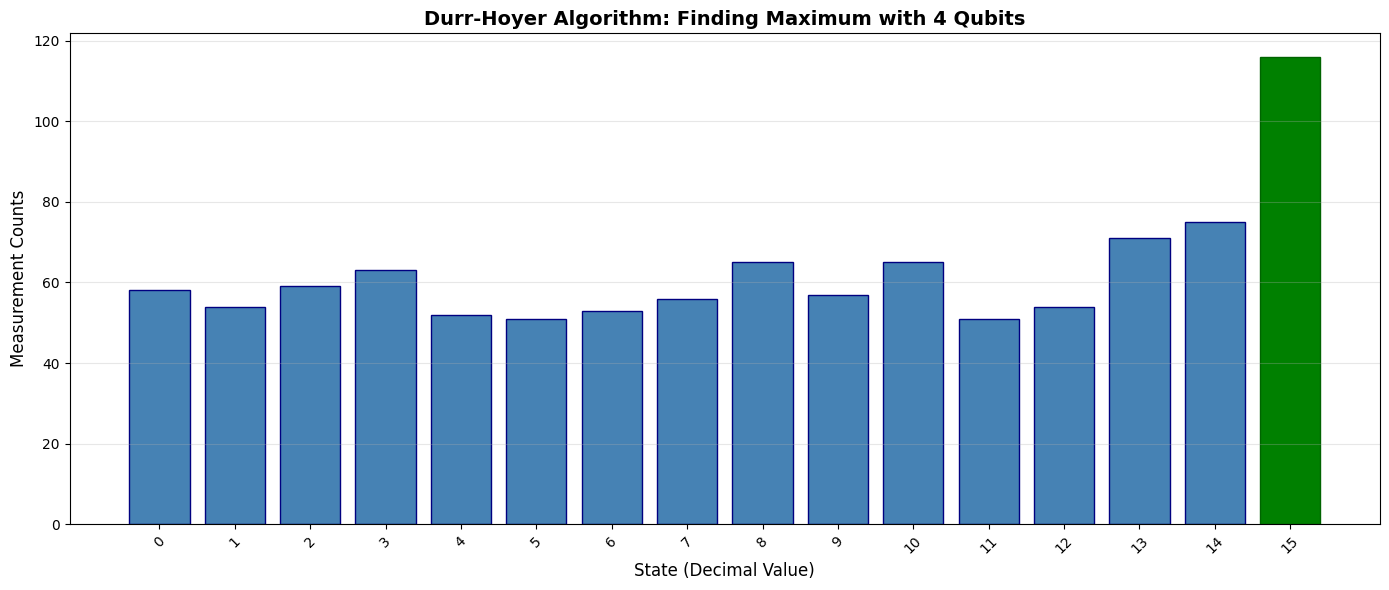


ALGORITHM SUMMARY
Target Maximum: |1111⟩ = 15
Most Probable Result: |1111⟩ = 15
Success Rate: 11.6%
Algorithm correctly identified the maximum: True


In [26]:
# Sort counts by decimal value for better visualization
sorted_counts = sorted(counts.items(), key=lambda x: int(x[0], 2))
bitstrings = [item[0] for item in sorted_counts]
values = [item[1] for item in sorted_counts]
decimal_labels = [str(int(bs, 2)) for bs in bitstrings]

# Create the bar plot
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(bitstrings)), values, color='steelblue', edgecolor='navy')

# Highlight the target state
target_index = bitstrings.index(format(target_state, '04b'))
bars[target_index].set_color('green')
bars[target_index].set_edgecolor('darkgreen')

plt.xlabel('State (Decimal Value)', fontsize=12)
plt.ylabel('Measurement Counts', fontsize=12)
plt.title('Durr-Hoyer Algorithm: Finding Maximum with 4 Qubits', fontsize=14, fontweight='bold')
plt.xticks(range(len(bitstrings)), decimal_labels, rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
max_state = max(counts, key=counts.get)
max_value = int(max_state, 2)
max_count = counts[max_state]

print(f"\n" + "="*50)
print(f"ALGORITHM SUMMARY")
print(f"="*50)
print(f"Target Maximum: |{format(target_state, '04b')}⟩ = {target_state}")
print(f"Most Probable Result: |{max_state}⟩ = {max_value}")
print(f"Success Rate: {(max_count/1000)*100:.1f}%")
print(f"Algorithm correctly identified the maximum: {max_value == target_state}")

## Step 7: Circuit Depth and Statistics

In [27]:
print(f"\nCircuit Statistics:")
print(f"="*50)
print(f"Number of Qubits: {circuit.num_qubits}")
print(f"Circuit Depth: {circuit.depth()}")
print(f"Number of Instructions: {len(circuit)}")
print(f"Number of Barriers: {circuit.count_ops().get('barrier', 0)}")


Circuit Statistics:
Number of Qubits: 4
Circuit Depth: 52
Number of Instructions: 130
Number of Barriers: 12
